In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load local version of gallifrey, before pip installed version, for debugging
import pathlib
import sys
import os

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [3]:
import yt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gallifrey.setup import data_setup
from gallifrey.utilities.dataframe import aggregated_dataframe, rename_labels
from gallifrey.visualization.visualization_utils import (
    set_plot_defaults,
    get_palette,
    FigureProcessor,
)

## DATA SETUP

In [4]:
snapshot = 127
resolution = 4096
sim_id = "09_18"

In [5]:
ds, mw, stellar_model, imf, planet_model = data_setup(
    snapshot=snapshot,
    resolution=resolution,
    sim_id=sim_id,
)


      DETECTED LOCAL MACHINE: Test snapshot loaded.

yt : [INFO     ] 2023-09-08 12:25:48,892 Calculating time from 1.000e+00 to be 4.318e+17 seconds
yt : [INFO     ] 2023-09-08 12:25:48,951 Parameters: current_time              = 4.318436660023809e+17 s
yt : [INFO     ] 2023-09-08 12:25:48,952 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-09-08 12:25:48,952 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-09-08 12:25:48,953 Parameters: domain_right_edge         = [100. 100. 100.]
yt : [INFO     ] 2023-09-08 12:25:48,953 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-09-08 12:25:48,953 Parameters: current_redshift          = 4.440892098500626e-16
yt : [INFO     ] 2023-09-08 12:25:48,954 Parameters: omega_lambda              = 0.682
yt : [INFO     ] 2023-09-08 12:25:48,954 Parameters: omega_matter              = 0.318
yt : [INFO     ] 2023-09-08 12:25:48,955 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 202

## PLOT SETUP

In [6]:
set_plot_defaults()
figure_directory = "Galaxy_components"

## CREATE DATA SOURCE

In [7]:
radius = 80
sphere_data = mw.sphere(radius=(radius, "kpc"))

In [8]:
components = ["thin_disk_stars", "thick_disk_stars", "spheroid_stars"]
data = aggregated_dataframe(
    components,
    ["circularity", "[Fe/H]", "[alpha/Fe]"],
    data_source=sphere_data,
    type_name="Component",
)

# rename components
data["Component"] = data["Component"].apply(
    lambda type: type.replace("_", " ").replace(" stars", "").title()
    if type.endswith("_stars")
    else type
)

# filtering values
filters = {"[Fe/H]": (-2.5, 1), "[alpha/Fe]": (-0.05, 0.3)}
for field_value, ranges in filters.items():
    data = data[data[field_value].between(*ranges)]

# rename labels
data, labels = rename_labels(data)

## FRACTION OF STARS IN COMPONENTS

In [9]:
data["Component"].value_counts(normalize=True)

Component
Thin Disk     0.490951
Thick Disk    0.314777
Spheroid      0.194272
Name: proportion, dtype: float64

## METALLICITY IN COMPONENTS

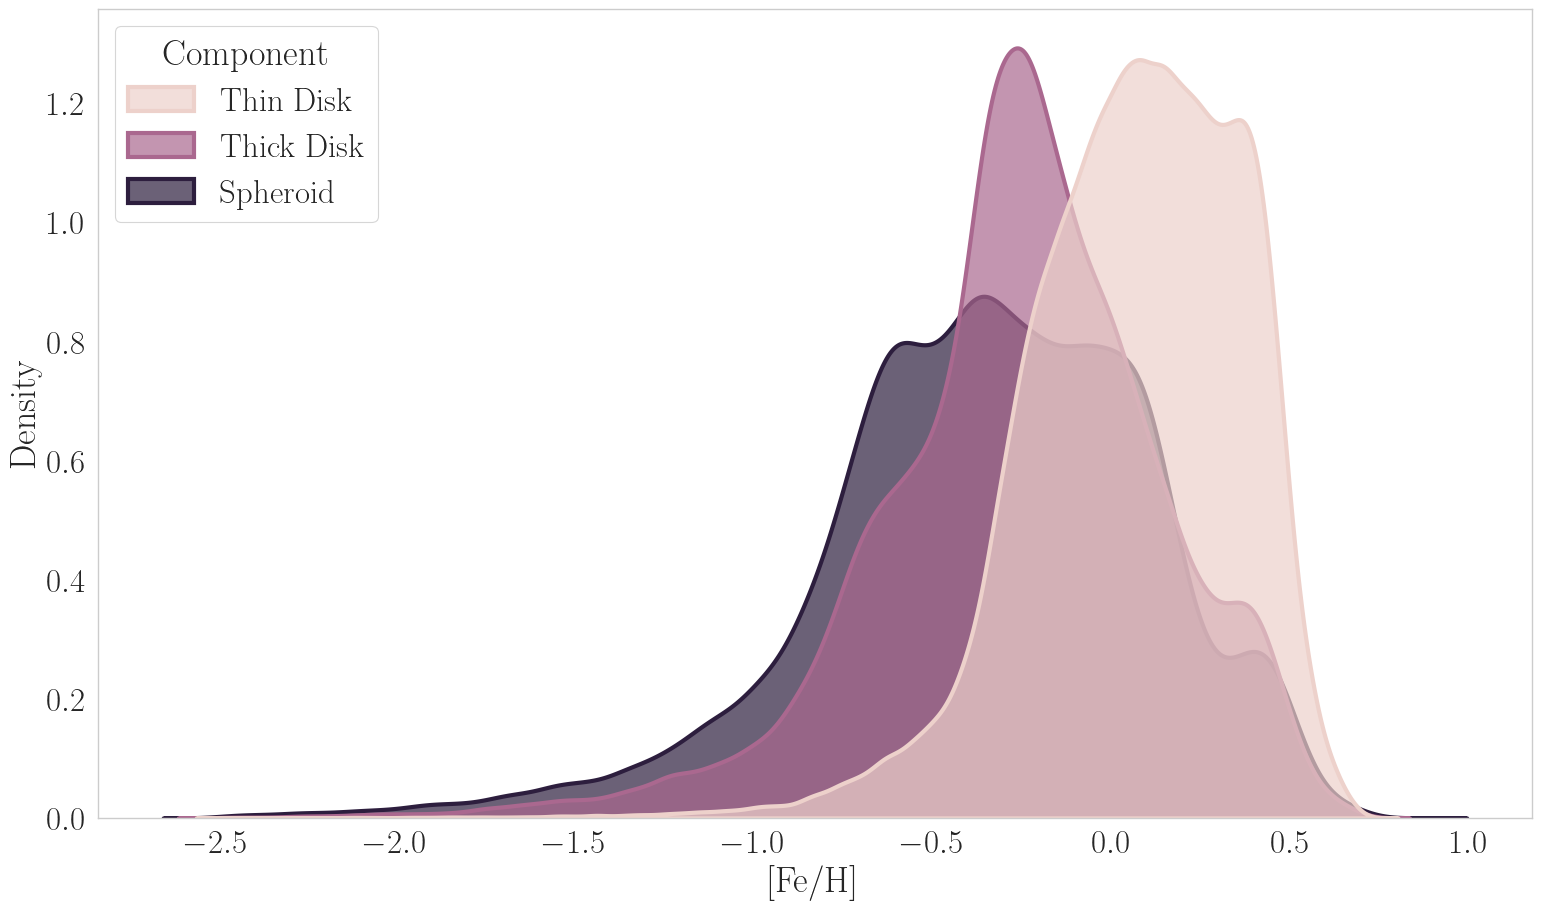

In [10]:
kdeplot_metallicity = sns.kdeplot(
    data,
    x="[Fe/H]",
    hue="Component",
    common_norm=False,
    fill=True,
    alpha=0.7,
    linewidth=3,
    gridsize=1000,
    palette=get_palette(n_colors=3),
)
sns.move_legend(kdeplot_metallicity, "upper left")
FigureProcessor(kdeplot_metallicity.figure).save(
    "kdeplot_metallicity.pdf", sub_directory=figure_directory
)

## [α/Fe] - [Fe/H] DIAGRAM

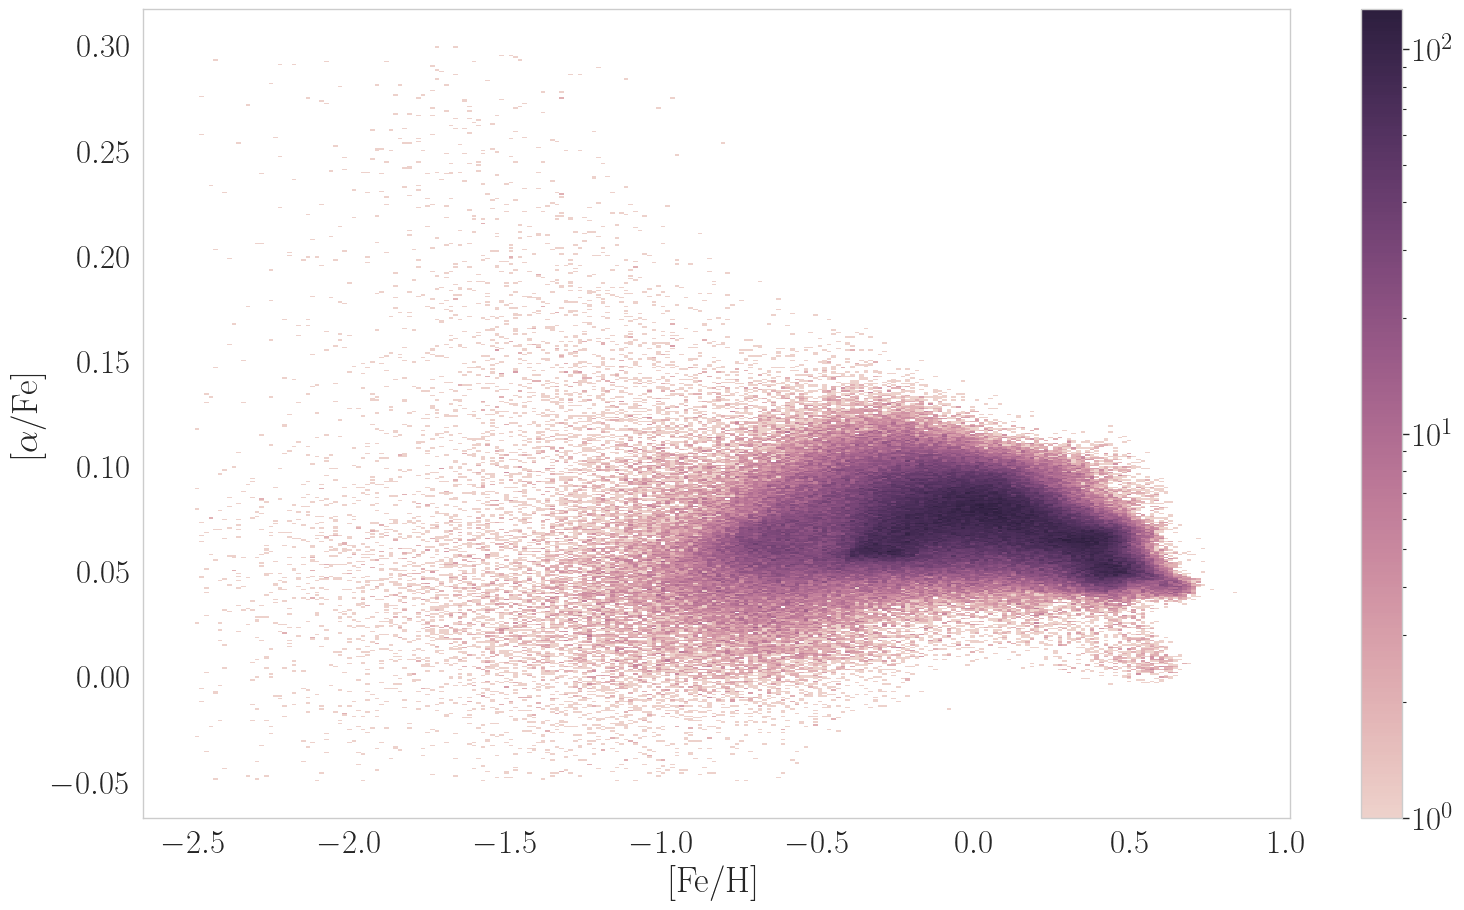

In [13]:
from matplotlib.colors import LogNorm

histogram2d_metallicity = sns.histplot(
    data,
    x=labels[0],
    y=labels[1],
    cbar=True,
    cmap=get_palette(as_cmap=True),
    norm=LogNorm(),
    vmin=None,
    vmax=None,
)
FigureProcessor(histogram2d_metallicity.figure).save(
    "histogram2d_metallicity.pdf", sub_directory=figure_directory
)